# Signal to noise calculations for the Toronto UV Small Satellite 


In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [44]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colours

from gunagala import imager

## Instructions

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 2 variants of the Australian Space Eye concept and a '5 lens' version of the Huntsman Telephoto Array. This version of the Huntsman Telephoto Array can represent the nominal full array of 10 lenses for the case where the lenses are divided equally between g' and r' band filters, which is expected to be the usual observing mode.

In [5]:
imagers = imager.create_imagers()
smallsat = imagers['toronto_prototype_1']  # 200mm aperture, f/10 telescope, FLI Kepler camera, two filters, Amanda's sky estimate.
waves_h = smallsat.wavelengths

BOB_DEBUG: local_version = ../gunagala/data/performance_local.yaml


## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Field of view

In [6]:
smallsat.pixel_scale

<Quantity 1.13445643 arcsec / pix>

In [7]:
smallsat.field_of_view

<Quantity [0.64537966, 0.64537966] deg>

In [8]:
smallsat.camera.resolution

<Quantity [2048., 2048.] pix>

### Filter profiles 

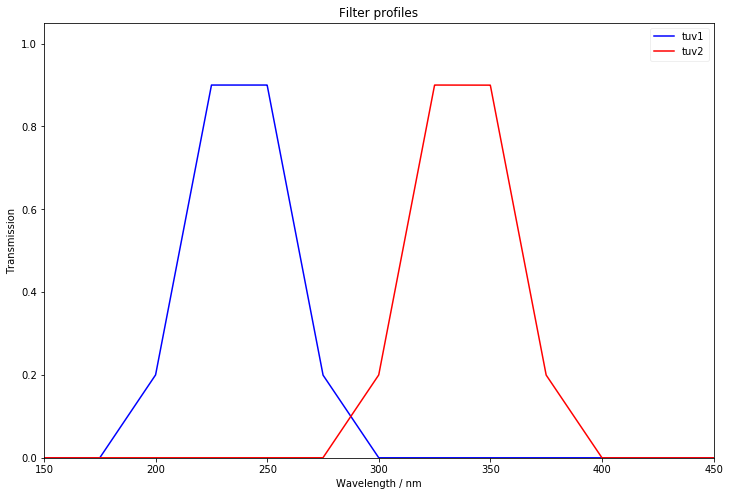

In [9]:
plt.plot(waves_h, smallsat.filters['tuv1'].transmission(waves_h), 'b-', label='tuv1')
plt.plot(waves_h, smallsat.filters['tuv2'].transmission(waves_h), 'r-', label='tuv2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(150, 450)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [10]:
smallsat.filters['tuv1'].FWHM

<Quantity 57.13016513 nm>

In [11]:
smallsat.filters['tuv1'].lambda_c

<Quantity 237.44724883 nm>

In [12]:
smallsat.filters['tuv2'].FWHM

<Quantity 57.13016513 nm>

In [13]:
smallsat.filters['tuv2'].lambda_c

<Quantity 337.42503781 nm>

### Image sensor quantum efficiency

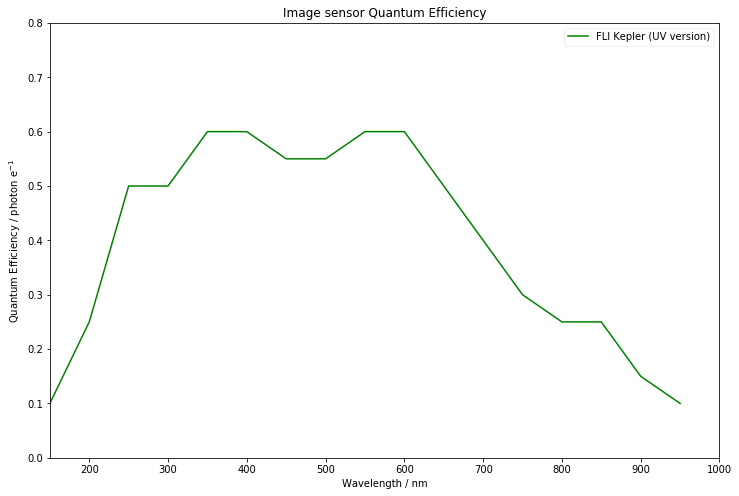

In [14]:
plt.plot(smallsat.camera.wavelengths, smallsat.camera.QE, 'g-', label='FLI Kepler (UV version)')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(150, 1000)
plt.ylim(0,0.8)
plt.gcf().set_size_inches(12,8)

### End-to-end efficiency

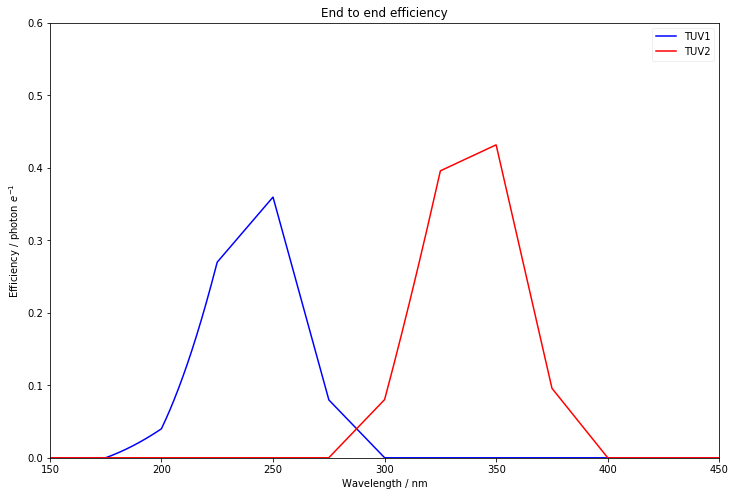

In [15]:
plt.plot(waves_h, smallsat.efficiencies['tuv1'], 'b-', label='TUV1')
plt.plot(waves_h, smallsat.efficiencies['tuv2'], 'r-', label='TUV2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(150, 450)
plt.ylim(0, 0.6)
plt.gcf().set_size_inches(12,8)

### PSF model

Uses a Moffat profile with 2 arcsecond FWHM an a shape parameter of 4.5. This is an upper limit for this value (which corresponded to the least 'wing-y' PSF) as this is the best fit value for a PSF where the scattering wings are due only to Kolmogorov atmospheric turbulence, i.e. instrumental scattering is assumed to be neglible.

In [16]:
smallsat.psf.FWHM

<Quantity 2. arcsec>

In [17]:
smallsat.psf.shape

Parameter('alpha', value=4.5)

In [18]:
smallsat.psf.peak

<Quantity 0.20533313 1 / pix>

In [19]:
smallsat.psf.n_pix

<Quantity 10.89140949 pix>

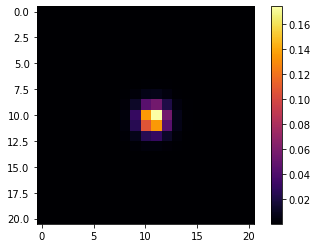

In [20]:
plt.imshow(smallsat.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno')
plt.colorbar()

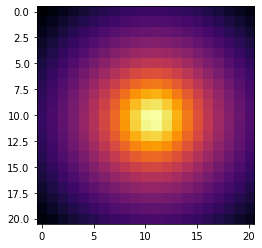

In [21]:
plt.imshow(smallsat.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno', norm=colours.LogNorm())

### Sky background model

We're using Amanda's sky estimates - need to document that stuff here.

In [22]:
smallsat.sky.surface_brightness('tuv1')

<Magnitude 26. mag(AB)>

In [23]:
smallsat.sky.surface_brightness('tuv2')

<Magnitude 25. mag(AB)>

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

#### Dark time

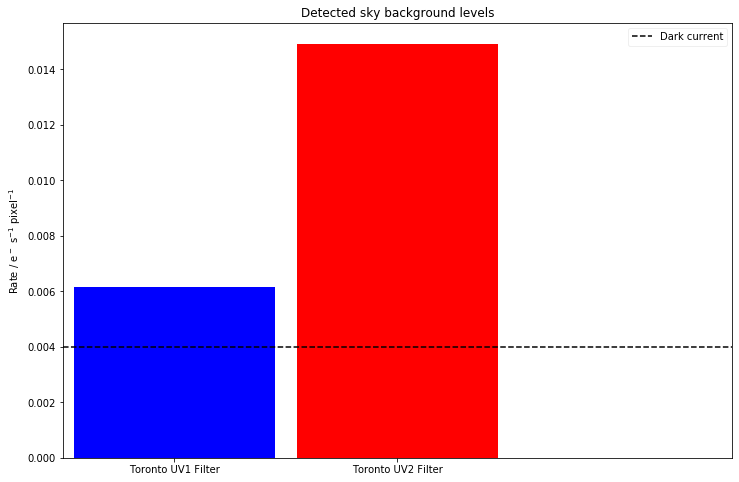

In [36]:
plt.bar((1, 2), (smallsat.sky_rate['tuv1'].value, smallsat.sky_rate['tuv2'].value),
        width=0.9, align='center', color=('b', 'r'))
plt.hlines(smallsat.camera.dark_current.value, 0.5, 3.5, linestyle='dashed', label='Dark current')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)

plt.xticks((1, 2), 
           ('Toronto UV1 Filter', 'Toronto UV2 Filter'))
plt.xlim(0.5,3.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

## Point source sensitivity

### Single 1 minute exposure

#### UV1 Filter (5 sigma sensitivity mag and saturation mags)

In [37]:
smallsat.point_source_limit(total_exp_time=1*u.minute,
                            filter_name='tuv1',
                            snr_target=5.0,
                            sub_exp_time=60*u.second)

<Magnitude 20.55974999 mag(AB)>

In [39]:
smallsat.point_source_saturation_mag(sub_exp_time=60*u.second, filter_name='tuv1')

<Magnitude 10.5639836 mag(AB)>

#### UV2 Filter (5 sigma sensitivity mag and saturation mags)

In [42]:
smallsat.point_source_limit(total_exp_time=1*u.minute,
                            filter_name='tuv2',
                            snr_target=5.0,
                            sub_exp_time=60*u.second)

<Magnitude 20.46568444 mag(AB)>

In [41]:
smallsat.point_source_saturation_mag(sub_exp_time=60*u.second, filter_name='tuv2')

<Magnitude 10.5254511 mag(AB)>

### Single exposures from 10 seconds to 5 minutes

In [30]:
ts = np.arange(10,301,5) * u.second

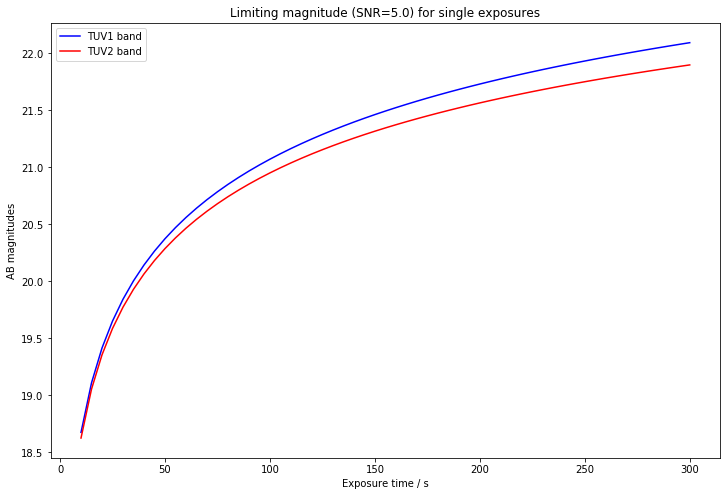

In [43]:
plt.plot(ts, smallsat.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='tuv1', snr_target=5.0), 
         'b-', label="TUV1 band")
plt.plot(ts, smallsat.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='tuv2', snr_target=5.0), 
         'r-', label="TUV2 band")
plt.legend()
plt.title("Limiting magnitude (SNR=5.0) for single exposures")
plt.xlabel("Exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)